# Part 2

In [2]:
# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_image, plot_shotrecord

from devito import configuration
configuration['log-level'] = 'WARNING'

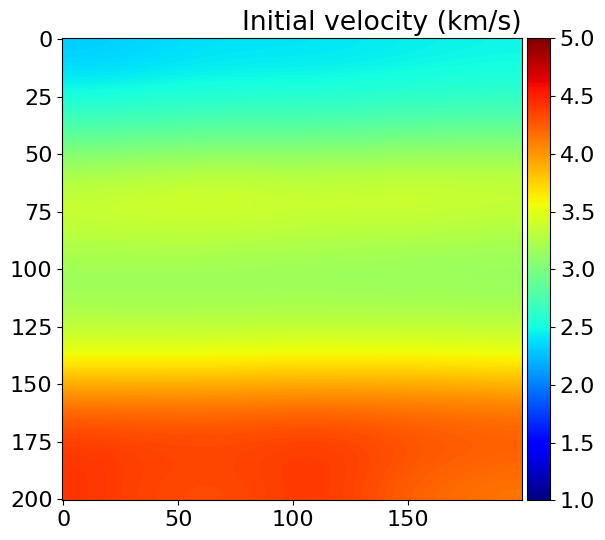

In [3]:
# Important: The values in this cell are defined according to the initial model we have been
# provided and should not be modified!!!!

# Load the initial/smoothed model from file. This smoothed model contains
# the values of vp on a grid defined with the following parameters:

spacing = (10., 10.) # Values in meters
origin = (0., 0.)

v_sm = np.load('data/initial_model.npy', allow_pickle=True)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

In [4]:
v_sm.shape

(200, 201)

In [5]:
# Create a Devito model
nbl = 10 # Thickness of the absorbing boundary layer
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

In [6]:
# Important: The values in this cell are defined according to our observed data
# and should not be modified!!!!

# The files shot0.npy through to shot10.npy located in data folder contain
# shot records resulting from the configuration defined below:

# Number of sources number = 11, and receivers = 101
nsrc=11; nrcv=101;

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 2.0 second (4000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)

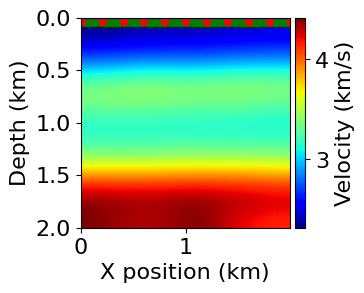

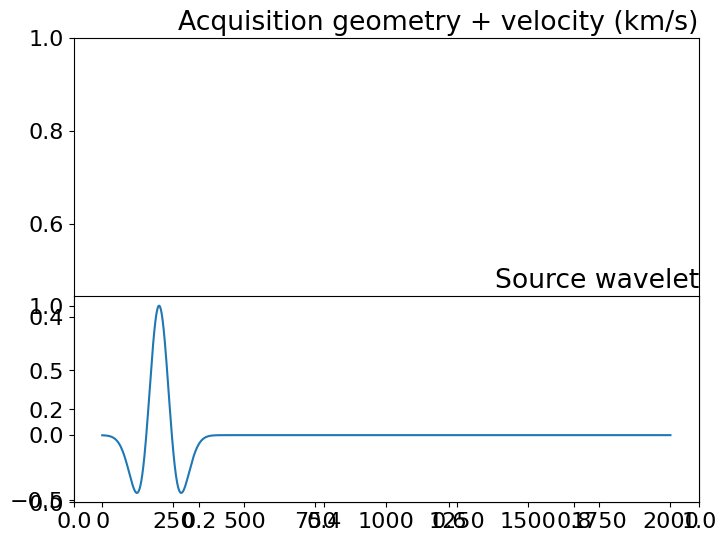

In [7]:
# Create the geometry object and solver object

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Plot acquisition geometry overlaid with initial Vp, and source wavelet
from examples.seismic.plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.subplot(2,1,1); plot_velocity(model0, source=src_loc, receiver=rcv_loc); 
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plt.subplot(2,1,2); plt.plot(geometry.src.time_values, geometry.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

In [8]:
# Compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='residual', grid=model0.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])
    
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

# Define bounding box constraints (clips) on the solution
# Note: Can modifying vmin, vmax result in a better final image?
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.0, vmax=5.0):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

## __Line Search__

### __Question2.1 In the FWI loop, replace how the step length `alpha` is set by a *simple line search* algorithm (i.e. you only need to consider the Armijo condition). You have seen the implementation of a simple line search for functions of scalars in Lecture 5. You should adapt this algorithm to work within the FWI framework.__

First we use the code from lecture5 to give us some inspiration. Then we know that as we are going to do line search, we need to compute the residual for different models. To implement this while not infect the key model, at the beginning, we store the data of model.vp and then updating to calculate the forward result and finally restore to the model.vp we stored.

The implementation of the line search is shown as below, all the parameters here have already been hypertuned, and the number of iteration has been set to 50 to make it able to show a better misift figure in the following part. And as alpha meas the step size to move. For the best dynamic way, it would keep decreasing. So I make it a global variable and can not become larger compared to the previous value of alpha. The reason is to reduce the unnecessary computation for each iteration to reduce the alpha from its initial value.

In [ ]:
def simple_line_search(model, objective_function, direction, alpha=1e-5, beta=0.38, c=1e-6):
    current_obj, _ = objective_function(model.vp)
    slope = np.dot(direction.data.flatten(), direction.data.flatten())

    for _ in range(10000):
        saved_vp = Function(name="vp_old", grid=model0.grid,space_order=2)
        saved_vp.data[:] = model.vp.data.copy()
        update_with_box(model.vp, alpha, direction)

        trial_obj, _ = objective_function(model.vp)

        update_eq = Eq(model.vp, Max(Min(saved_vp, 5.0), 1.0))
        Operator(update_eq)()

        if trial_obj - current_obj <=  c * alpha * slope:
            break
        alpha *= beta

    return alpha

And this is able to run with the following FWI Iteration.

In [ ]:
# Run FWI with gradient descent
fwi_iterations = 50 # We'll want to increase this value to get better images
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = fwi_gradient(model0.vp)
    
    # We add decay to step length "alpha" to stabilize gradient descent
    # Note: This is not a very good choice of alpha, we can do much better!
    alpha = simple_line_search(model0, fwi_gradient, direction, alpha=alpha)

    # Update the velocity model in-place and enforce min/max value clips
    update_with_box(model0.vp, alpha, direction)
    
    # Log the progress of objective function value
    print('Iteration:', i, 'Objective:', objective[i], 'Alpha:', alpha)

__Optimizing for line search__

However, the code above is not run for the result. Although the hypertune has been implemented for this method (the value for alpha, beta, c), we see that there is still inefficiency in the implement above:

1. In the line search function, we need to calculate the residual for each time iteration. However, there are many unnecessary operations in _fwi_gradient_ function because we only need the residual here, which cost more computation. We can set a flag for the _fwi_gradient_ function to judge whether all operations need to be execute.

2. The last time of search for alpha in function _simple_line_search_ will still do a backward operation. And then in the FWI iteration, the model is going to do forward again. This is quite redundant. We can combine them in the search alpha function.

Then we are going to optimize them and run them.

In [9]:
def optimize_fwi_gradient(vp_in, flag=True):    
    # Create symbols to hold the gradient, data residual and data
    grad = None
    if flag:
        grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='residual', grid=model0.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])
    
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        if flag:
            solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

In [13]:
def optimize_line_search(model, objective_function, direction, alpha=1e-5, beta=0.38, c=1e-6):
    current_obj, _ = objective_function(model.vp, flag=False)
    slope = np.dot(direction.data.flatten(), direction.data.flatten())

    for _ in range(10000):
        saved_vp = Function(name="vp_old", grid=model0.grid,space_order=2)
        saved_vp.data[:] = model.vp.data.copy()
        update_with_box(model.vp, alpha, direction)

        new_obj, _ = objective_function(model.vp, flag=False)

        if new_obj - current_obj <=  c * alpha * slope:
            break

        update_eq = Eq(model.vp, Max(Min(saved_vp, 5.0), 1.0))
        Operator(update_eq)()
        alpha *= beta

    return alpha

# Run FWI with gradient descent
fwi_iterations = 50 # We'll want to increase this value to get better images
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

    print('Iteration:', i, 'Objective:', objective[i], 'Alpha:', alpha)

Iteration: 0 Objective: [11541867.65101837] Alpha: 1e-05
Iteration: 1 Objective: [8099450.45683714] Alpha: 1e-05
Iteration: 2 Objective: [5532233.67814299] Alpha: 1e-05
Iteration: 3 Objective: [4271428.75516274] Alpha: 1e-05
Iteration: 4 Objective: [4071129.66819008] Alpha: 3.8000000000000005e-06
Iteration: 5 Objective: [2678231.62102887] Alpha: 3.8000000000000005e-06
Iteration: 6 Objective: [2381439.31516353] Alpha: 3.8000000000000005e-06
Iteration: 7 Objective: [2171604.49029144] Alpha: 3.8000000000000005e-06
Iteration: 8 Objective: [2002465.48226304] Alpha: 3.8000000000000005e-06
Iteration: 9 Objective: [1863820.15695681] Alpha: 3.8000000000000005e-06
Iteration: 10 Objective: [1748525.16082462] Alpha: 3.8000000000000005e-06
Iteration: 11 Objective: [1651307.36635854] Alpha: 3.8000000000000005e-06
Iteration: 12 Objective: [1568219.45042636] Alpha: 3.8000000000000005e-06
Iteration: 13 Objective: [1496341.40874466] Alpha: 3.8000000000000005e-06
Iteration: 14 Objective: [1433530.7734609

### __Using mathematical definitions where appropriate, explain the implementation of your simple line search algorithm__

To start with, let's __explain__ what is __Armijo condition__. Given a differentiable objective function $F(m)$, where $m$ is the model parameter. Suppose our current model parameters are $m$, the gradient direction is $∇F(m)$, and we want to update the model parameters along the opposite direction of the gradient $−∇F(m)$ to reduce F. The Armijo condition stipulates that a suitable step size α should satisfy the following inequality:

\begin{equation}
F(m+\alpha d) - F(m) <= c\alpha∇F(m)^Td
\tag{1}
\end{equation}

where $\alpha$ is the step size, $d$ is the update direction, where
\begin{equation*}
 d=-\frac{\nabla F(\mathbf{m})}{||\nabla F(\mathbf{m})||}.
\end{equation*}
(In the steepest descent method, $d=-∇F(m)$), $c$ is a small constant value between, $F(m+\alpha d)$ is the objective function value after updating the model parameters in the direction $d$ with $\alpha$ as the step size, $F(m)$ is the the objective function value of the current model parameters, $∇F(m)^Td$ is the dot product of gradient and update direction.

Then, let's use mathematic to prove this.

Our goal is to prove that the step size selected by the Armijo condition can indeed guarantee a sufficient decrease in the objective function.

First, considering that the objective function $F$ is differentiable at $m$, according to Taylor expansion, we have:

\begin{equation}
F(m+\alpha d) = F(m) + \alpha∇F(m)^Td + O(\alpha)
\tag{2}
\end{equation}

Among them, $O(\alpha)$ represents the term that as α tends to 0, $\frac{O(\alpha)}{\alpha}$ also tends to 0. When $\alpha$ is small, $O(\alpha)$ can be ignored, then we have:

\begin{equation}
F(m+\alpha d) ≈ F(m) + \alpha∇F(m)^Td
\tag{3}
\end{equation}

In order to ensure that $F(m+\alpha d) < F(m)$, that is to ensure that the objective function value decreases, we need $\alpha∇F(m)^Td$ to be negative. In the steepest descent method, $d=-∇F(m)$, then $\alpha∇F(m)^Td$ is already negative. However, this is not enough, we also need an additional condition to control the degree of decline, which is the role of the $c\alpha∇F(m)^Td$ term in the Armijo condition.

By choosing $\alpha$ that satisfies the Armijo condition, we ensure that not only does the objective function decrease at each step, but it also decreases by at least $c$ times $\alpha$ times the dot product of the gradient and the update direction. Such a selection strategy ensures that the algorithm maintains convergence while also having a certain search efficiency.

The we can rewrite the form of the Armijo condition to:

\begin{equation}
F(m+\alpha d) - F(m) <= c\alpha d^2
\tag{1}
\end{equation}

Then, Let's map this to our implement code.

The function $F()$ in this equation is the object_function in our code. To be more specific, this $F()$ function is the _fwi_gradient()_ function in our code and we only need the first return value(the residual) as the result of $F()$.

The parameter $m$ in this equation is the model.vp in our code. It represent the velocity for the current time. The $F(m)$ in our code is the fwi_gradient(model.vp)[0].

The parameter $\alpha$ in our code is the variable _alpha_, which is the step size.

The parameter $d$ in our code is the variable _direction_ which is calculated by the function _fwi_gradient()_ and is its second return value.

The parameter $c$ in our code is the variable _c_ with default value 1e-6.

All the mathematical explanation and justification have been finished till here. 

Then let's have a quick explanation for the algorithm.

The logic for the algorithm in this function is simple:
1. We calculate the objective for the current time.
2. Start an iteration until we find a appropriate _alpha_

For each iteration, we have:
3. save the current velocity gradient(model.vp).
4. update model.vp to calculate the objective for the next time.
5. apply the Armijo condition to justify the current alpha is suitable.

If it is suitable, we will break the loop and return the current value of alpha.

If it is not suitable, we will reseting/restore the model.vp using the one we stored in step3 and update the value of alpha by applying alpha = alpha * beta. Then continue to the next iteration.

###

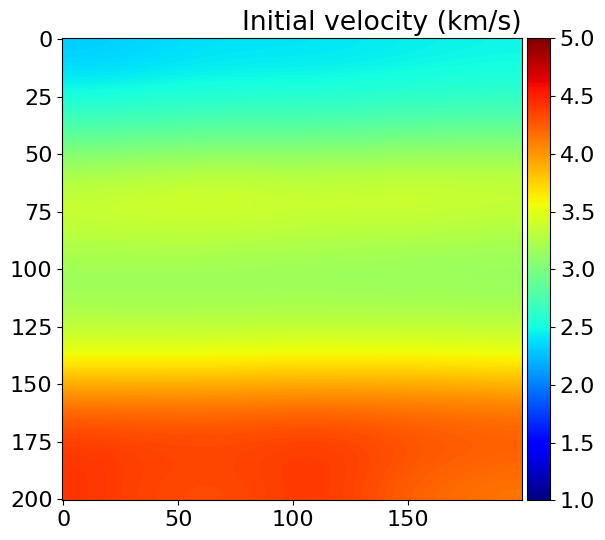

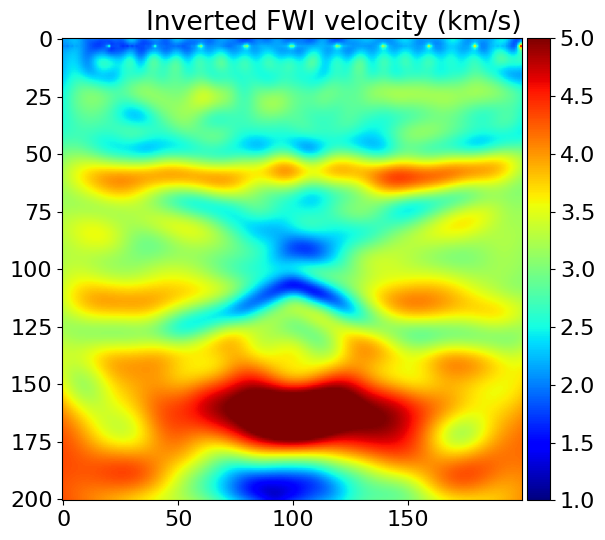

In [16]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.0, vmax=5.0, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

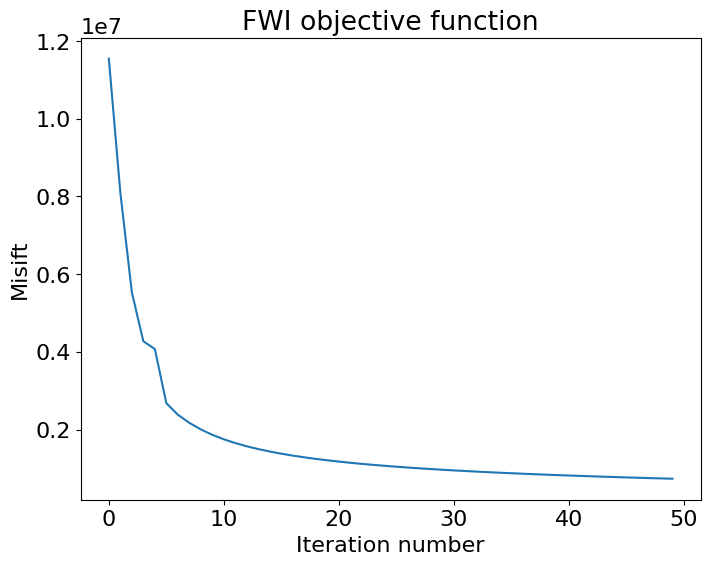

In [15]:
#plot objective function
plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

## 2.2 Modify **4** other aspects of the FWI algorithm. List each modification you implement, discuss the reason behind each modification and its effect on the final image/result.
    - Changing the number of FWI iterations
    - Modifying the absorbing boundary layer width
    - Modifying the discretization order of the PDE
    - Changing the grid resolution

As the beginning of this part, we are going to encapsulate all the functions above so that we can use them easily for modification and result analysis.

In [19]:
def model_modification(nbl=10, fwi_iterations=5):
# nbl=10
# fwi_iterations=5
    spacing = (10., 10.) # Values in meters
    origin = (0., 0.)
    v_sm = np.load('data/initial_model.npy', allow_pickle=True)

    # Create a Devito model
    model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
                shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


    nsrc=11; nrcv=101;
    src_loc = np.empty((nsrc, 2), dtype=np.float32)
    src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
    src_loc[:, 1] = 30.
    rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
    rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
    rcv_loc[:, 1] = 30.

    t0 = 0.
    tn = 2000.
    f0 = 0.005

    geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model0, geometry, space_order=2)

    # Run FWI with gradient descent
    alpha = 1e-5
    objective = np.zeros((fwi_iterations, 1))
    for i in range(0, fwi_iterations):
        # Compute the current FWI objective function and gradient
        objective[i], direction = optimize_fwi_gradient(model0.vp)
        
        alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

    plt.title('Initial velocity (km/s)', loc='right')
    plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

    plt.title('Inverted FWI velocity (km/s)', loc='right')
    plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

    plt.figure()
    plt.plot(objective)
    plt.xlabel('Iteration number')
    plt.ylabel('Misift')
    plt.title('FWI objective function')
    plt.show()

### Modification 1 - Changing the number of FWI iterations

The first modification I choose to do is to increase the number of FWI iterations. The original iteration time is 5 and I increase it to 50.

#### Discussion

__Reasons for increasing the number of iterations__

Convergence: FWI is an optimization process based on gradient descent, which reduces the error between observed data and simulated data through step-by-step iteration. Increasing the number of iterations can give the algorithm more opportunities to approach the global optimal solution or a better local optimal solution, thereby improving the accuracy of the inversion results.

Solve complex geological structure problems: For areas with complex underground media or drastic parameter changes, more iterations are needed to carefully adjust model parameters to ensure that the model can accurately reflect the complexity of the underground media.

Increased resolution: Increasing the number of iterations helps to fine-tune the velocity model, especially in critical areas of the model, resulting in higher-resolution subsurface velocity images.

__Impact on final image/result__

Improvement of image quality: As the number of iterations increases, the FWI algorithm can more accurately fit the observation data, thereby generating a velocity model that is closer to the real underground situation. This means the final images will have better resolution, revealing underground structures more clearly.

Reduce uncertainty: More iterations can help the algorithm overcome the problem of local optimal solutions and reduce uncertainties caused by improper initial model selection or local optimal traps.

Increase in computational cost: Although increasing the number of iterations has many advantages, it will also increase computational time and resource consumption accordingly. Therefore, a reasonable balance needs to be found between algorithm performance improvement and computational cost.

#### Practical Analysis

The first modification I choose to do is to increase the number of FWI iterations. The original iteration time is 5 and I increase it to 50. Let's have a look at the result of this first.

For the number of iteration is 5:

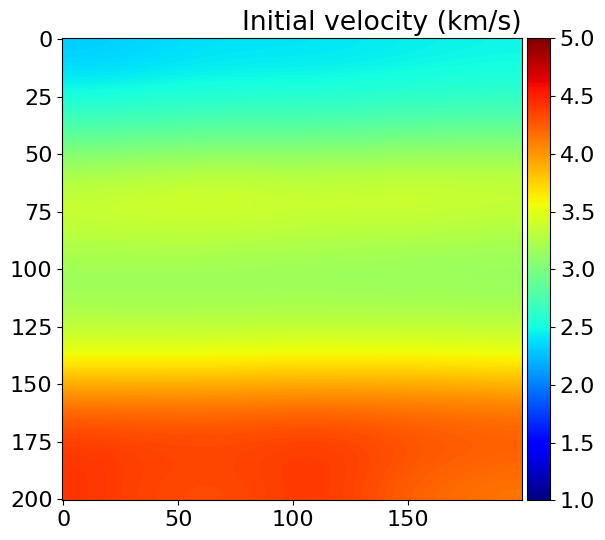

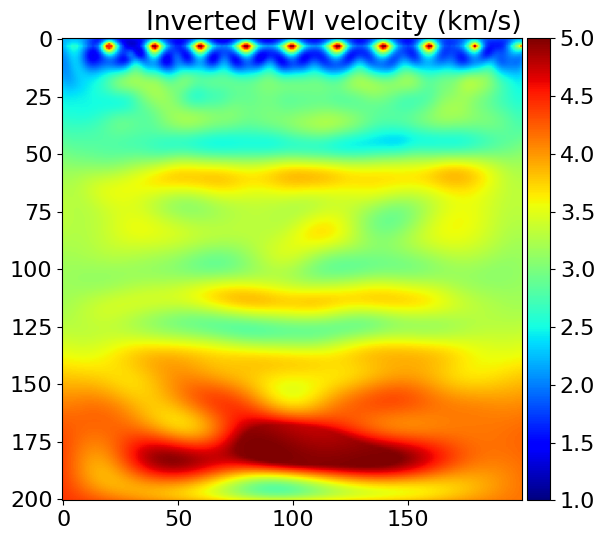

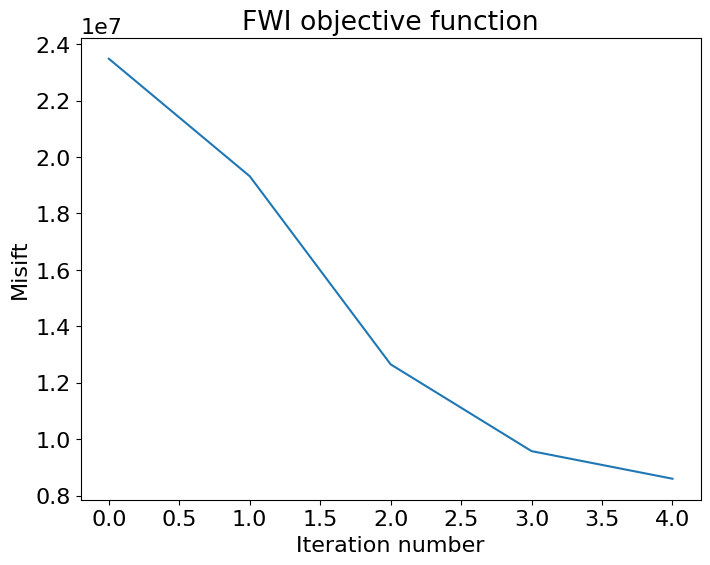

In [16]:
model_modification(fwi_iterations=5)

From the Inverted FWI velocity image, we see this model shows more structural details than the initial model. We can see that the velocity changes spatially more complexly, showing possible stratigraphic interfaces. Especially in areas with greater depth, velocity changes are more pronounced, which may indicate complex underground structures such as faults or discontinuities in the rock formations.

From the FWI objective function, we see that as the number of iterations increases, the objective function (usually the sum of squares of the data residuals) gradually decreases. Ideally, the objective function should decrease smoothly and tend to a smaller value as iterations proceed. This shows that the match between simulated data and observed data is gradually improving. As can be seen from the figure, in the first 5 iterations, the objective function has an obvious downward trend, which means that the inversion process is gradually improving the velocity model.

__Analysis__
1. After 5 iterations, the velocity model showed a more complex underground structure than the initial model. This means that the FWI algorithm is able to extract more information from the data and convert this information into improvements in the velocity model.
2. The objective function decreases significantly with the number of iterations, which usually indicates that the algorithm is correctly updating the velocity model to better fit the data.
3. Although the objective function shows a downward trend, we cannot be sure whether the minimum possible error has been reached. In practical applications, more iterations may be required to confirm whether convergence is achieved.
4. Based on the decline of the objective function and the final speed model, we can consider continuing to increase the number of iterations to further improve the model.

Then the iteration number is increased to 20:

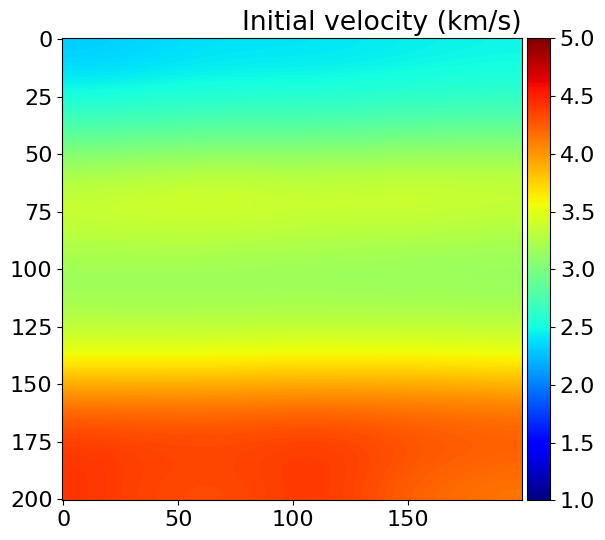

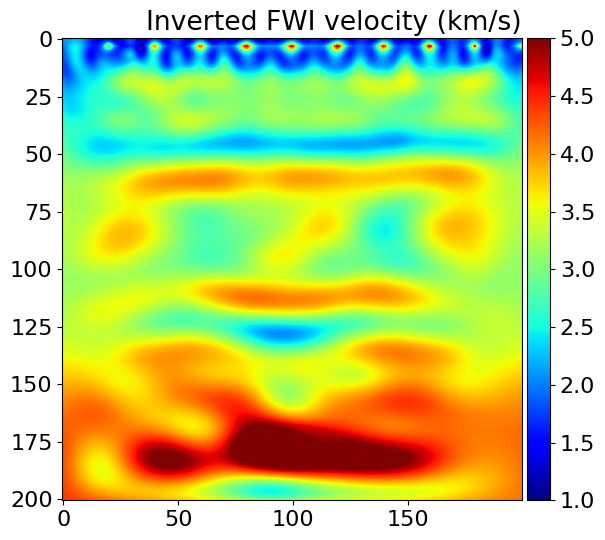

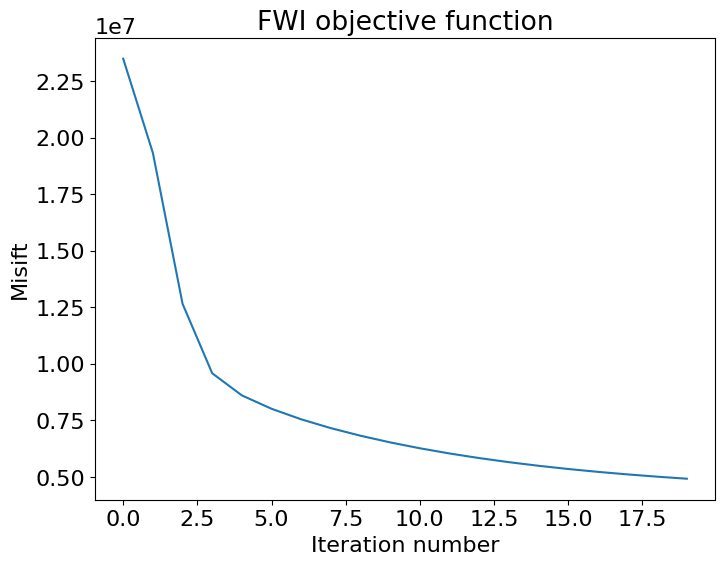

In [20]:
model_modification(fwi_iterations=20)

From the Inverted FWI velocity image, after 20 iterations, the velocity model showed more detailed structural information. Compared with the previous 5 iterations, the layers of the underground structure are clearer and the interface with velocity changes is more obvious. This shows that the algorithm is continuing to improve the model, bringing it closer to the distribution of actual subsurface velocities.

From the FWI objective function, the objective function chart shows that during the 20 iterations, the error reduction trend slows down significantly, but is still declining. Usually, the objective function will decline rapidly at the beginning of the iteration, and the decline will slow down when approaching the optimal solution. The curve trend in the figure shows that the model is stabilizing as the number of iterations increases.

__Analysis__
1. 20 iterations significantly improved the velocity model, providing more information about the underground structure. If these structures reflect real geological features, then the inversion process is successful.
2. A slower downward trend in the objective function may mean that the optimal solution is close, but there is not enough information to determine whether complete convergence has occurred.
3. Based on the current situation, I decide to continue increasing the number of iteration.

Then the iteration number is increased to 50:

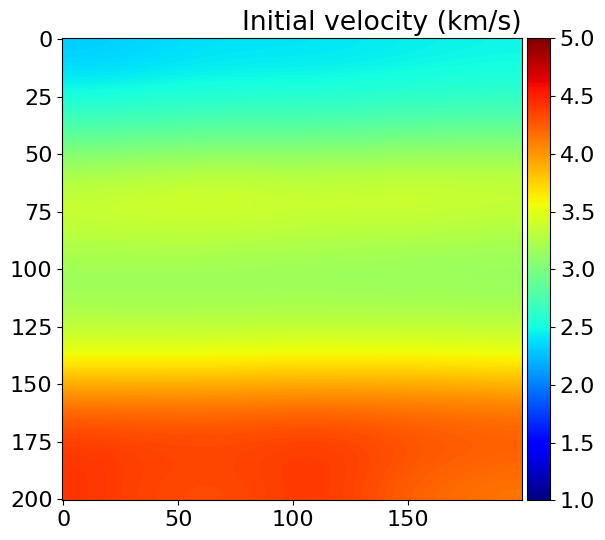

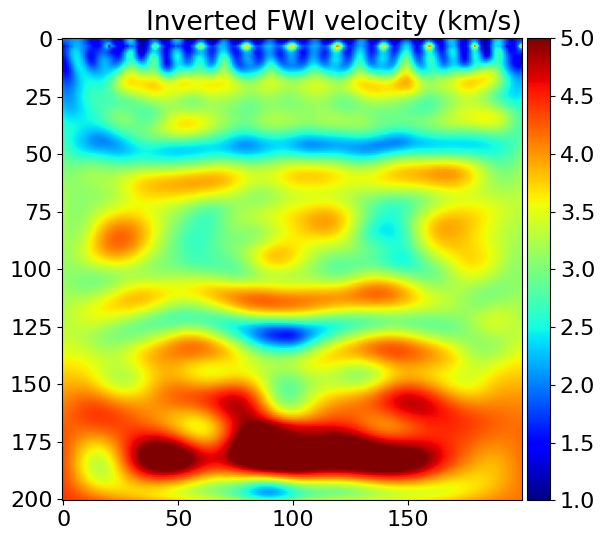

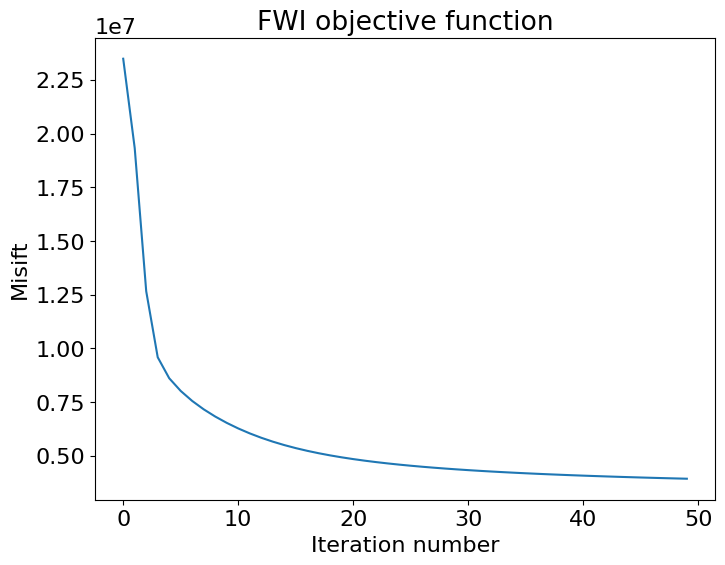

In [21]:
model_modification(fwi_iterations=50)

From the Inverted FWI velocity image, compared with the results of the first 20 iterations, the velocity model after 50 iterations is more complex and exhibits more details. The apparent layering and velocity discontinuities in the map may indicate geological interfaces. In addition, the velocity distribution in the deep layers is more complex and may reveal changes in the stratigraphy or the existence of faults.

From the FWI objective function image, the curve of the objective function shows that the error decreases rapidly in the initial iterations, and the downward trend slows down after 20 iterations, until the objective function curve becomes flat after 50 iterations. This usually means that the model is approaching a stable state, and even if the number of iterations is further increased, the magnitude of the model improvement may be small.

__Analysis__
1. The model after increasing to 50 iterations showed higher refinement, indicating that increasing the number of iterations can indeed help the inversion process converge to a more accurate solution.
2. A flattening of the objective function curve indicates that the model may be approaching a potential optimal solution or local minimum.
3. As the number of iterations increases, each time has diminishing returns. From a computational resource perspective, it may no longer be economical to continue increasing the number of iterations.

__Conclusion__
According to the results of 50 iterations, the model has shown obvious geological structural characteristics. At this point, it is important to verify the reliability of the model with geological knowledge or other independent data. If the model is consistent with known geological information, then further iterations may not lead to significant improvements. If the model deviates significantly from the actual situation, you can consider using a different initial model or changing other inversion parameters to improve the results. And the number of iteration is chosen to 50.

### Modification 2 - Modifying the absorbing boundary layer width

The second modification I choose to do is to increase the absorbing boundary layer width. The original nbl is 10 and I increase it to 30.

#### Discussion

__Reasons for adding nbl(absorbing boundary layer width)__


Reduce boundary reflections: Increasing the absorptive boundary layer width can more effectively absorb artificial boundary reflections due to computational domain constraints, thereby reducing the impact of these reflections on the simulation data.

Improved model accuracy: By reducing boundary reflections, the propagation of seismic waves in the subsurface medium can be simulated more accurately, which is critical to the accuracy of the inversion results.

Adapt to low-frequency data: For low-frequency seismic data, the wavelength of the fluctuation is longer, so a wider absorption boundary layer is needed to effectively absorb these low-frequency fluctuations and avoid reflection at the boundary of the computational domain.



__Impact on final image/result__


Improved image clarity: After increasing nbl, the inverted velocity model will be clearer, especially at the edges of the model, due to the reduced interference from boundary reflections.

Increased computational resource consumption: Wider absorptive boundary layers mean that the overall size of the computational domain will increase, which will increase the consumption of computational resources, including memory and CPU time.

May affect the inversion speed: the inversion process will slow down due to increased computing resource consumption.

Reduced boundary effects: In some cases, the physical properties of the subsurface medium can be more accurately assessed due to the reduction of boundary effects, especially in areas close to boundaries.

#### Practical Analysis

First let's have a look the result of nbl=10.

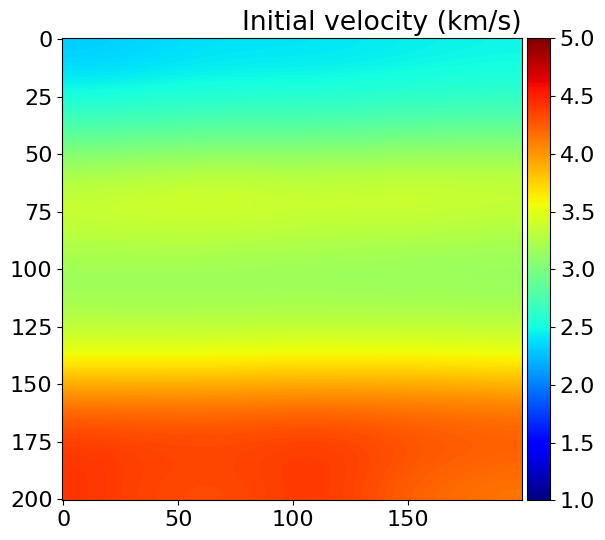

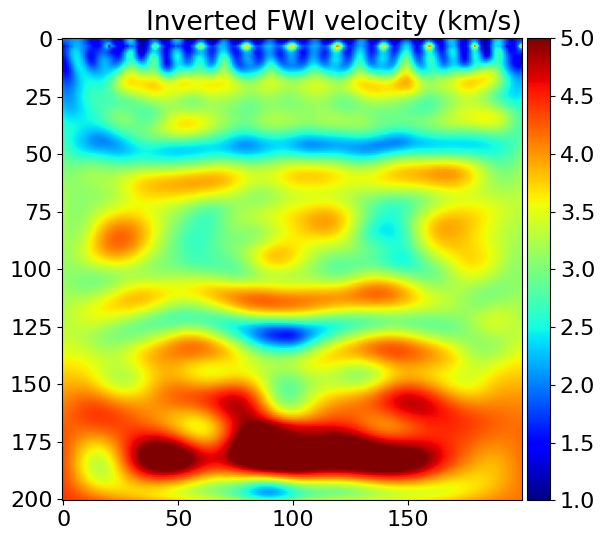

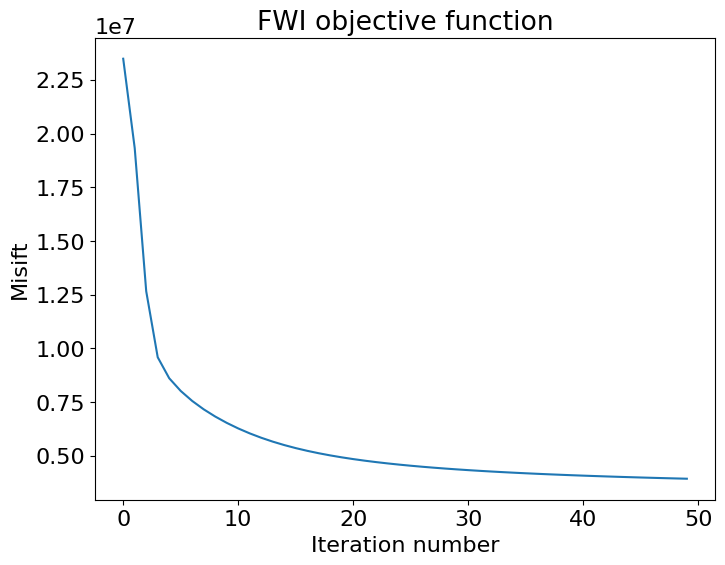

In [ ]:
model_modification(nbl=10, fwi_iterations=50)

From the Inverted FWI velocity image, after 50 iterations, the velocity model revealed more details of the subsurface structure. It can be seen that velocity discontinuities are more pronounced, which may represent stratigraphic interfaces. However, some stripe-like patterns appear in the edge regions of the model, which may be caused by boundary reflections. In actual geological structures, this stripe-like pattern may be unrealistic, indicating that the fluctuations at the boundaries are not fully absorbed.

From the FWI objective function, the objective function graph shows that as the number of iterations increases, the fitting error (misfit) of the model gradually decreases, especially in the first 10 iterations. Nearing 50 iterations, the objective function levels off, indicating that the model may be close to the optimal solution or stuck in a local minimum.

__Analysis__
1. The stripe-like pattern in the edge region may be a direct consequence of insufficient width of the absorbing boundary layer, resulting in the boundary reflection not being effectively absorbed.
2. The central region of the model shows a relatively reasonable subsurface velocity distribution, which is a significant improvement compared to the initial velocity model.
3. The absorptive boundary layer width needs to be increased to reduce unphysical reflections in the edge regions.


Then the absorbing boundary layer width increase, where nbl = 20:

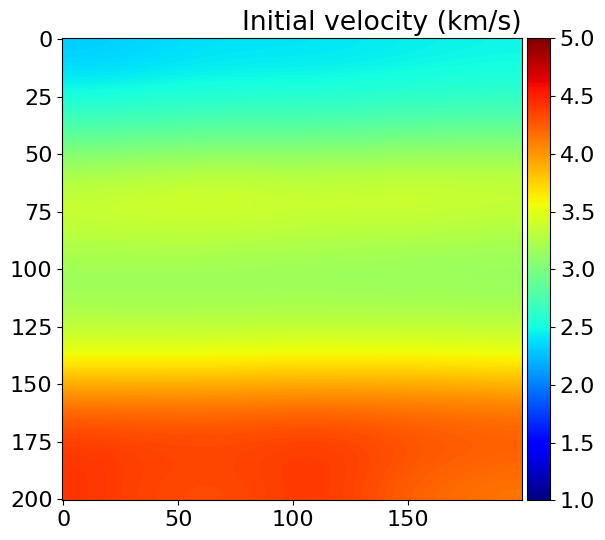

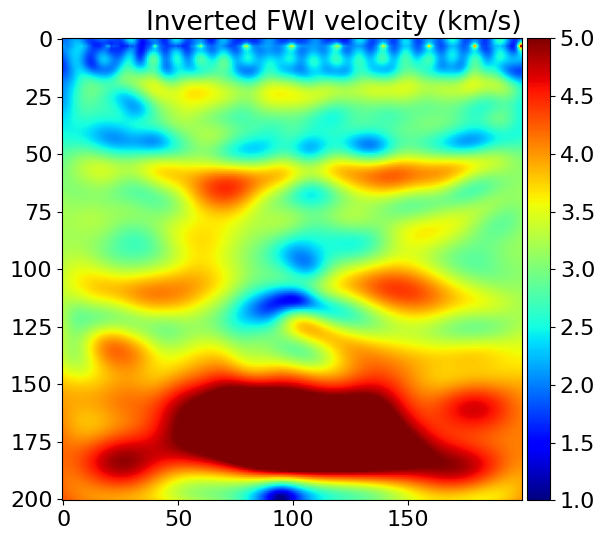

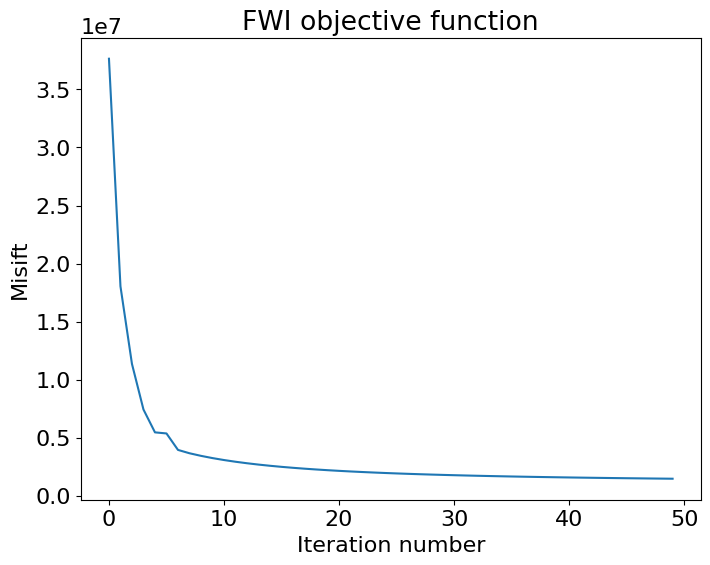

In [26]:
nbl=20
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

From the Inverted FWI velocity image, compared with when nbl is 10, the boundary stripe-like pattern in the velocity model seems to be reduced after increasing nbl to 20, indicating that the boundary reflection effect is improved. The subsurface structure is more clearly characterized in the central area, showing the complexity of the velocity distribution and potential interfaces of the formations.

From the FWI objective function, the objective function shows that the error decreases rapidly in the first 10 iterations and then levels off. Compared with the objective function when nbl is 10, changing nbl does not seem to significantly affect the overall downward trend of the objective function.

__Analysis__
1. Increasing nbl can reduce reflections at computational boundaries, thereby reducing non-physical effects at the edges of the model. Improved boundary processing helps to restore the velocity model in edge areas more accurately.
2. Increased absorptive boundary layer width may help restore model detail better, especially in regions close to the boundaries.
3. Increasing nbl increases the size of the computational cost, thereby increasing computational resource usage and computational time.
4. Increasing nbl from 10 to 20 helps improve boundary effects but has little effect on the overall objective function downward trend. Therefore, an increase in nbl is positive for improving FWI results.
5. Can further optimizing the width of the absorbing boundary layer.


Then the absorbing boundary layer width increase, where nbl = 30:

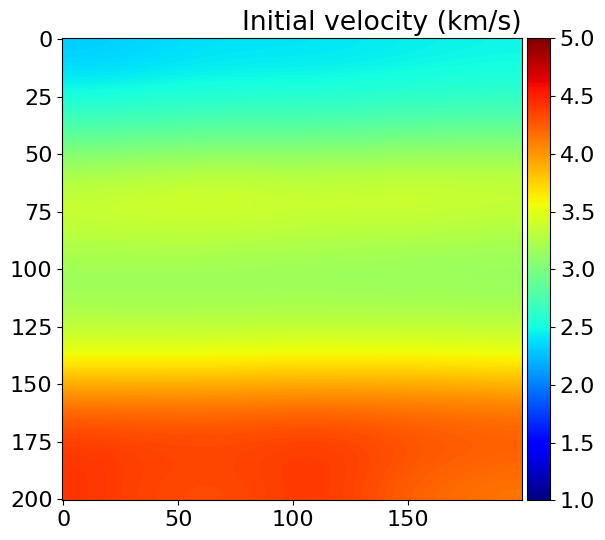

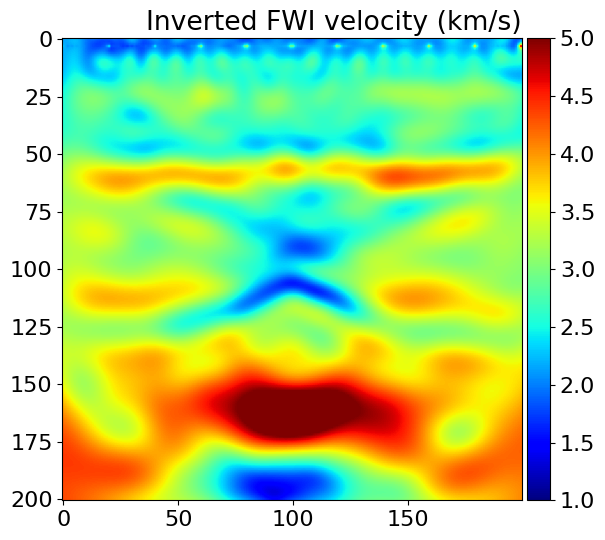

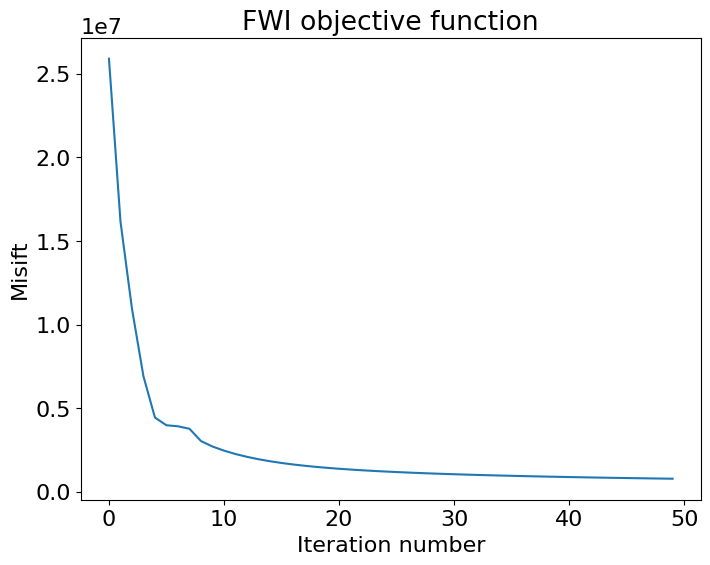

In [27]:
nbl=30
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

From the Inverted FWI velocity image, compared to the previous results with nbl of 10 and 20, the velocity model this time shows fewer streak-like artifacts in the boundary region, suggesting that increasing the width of the absorbing boundary layer helps reduce boundary reflections, thereby improving the inversion quality. Structural features in the center of the velocity model become clearer and velocity changes more pronounced, which may mean a more accurate representation of the subsurface structure.

From the FWI objective function, the curve of the objective function shows that the error is significantly reduced during 50 iterations, especially in the first few iterations. The error downward trend slows down in later iterations, which may indicate that the optimal solution is approaching or that it is stuck in a local minimum.

__Analysis__
1. After increasing nbl to 30, the fringes at the boundary are reduced, which shows that the performance of the absorbing boundary is improved and the conditions of the infinite domain are simulated more effectively.
2. Subsurface structural features are more pronounced in the center region of the model, indicating that the inversion algorithm is able to provide a more accurate subsurface velocity model.
3. A wider nbl will increase the size of the model and increase the consumption of computing resources. A balance needs to be found between improving results and computing costs. Therefore, we no longer continue to increase nbl and set nbl at 30.

### Modification 3 - Modifying the discretization order of the PDE

The discretization order modification I choose to do is to increase the order. The original space_order is 2 and I increase it to 6.

#### Discussion

__Reasons for adding space_order__

Improve model accuracy: Increasing the discretization order can improve the accuracy of simulating seismic wave propagation, especially when dealing with complex geological structures.

Accuracy of wave field propagation: High-order differencing can better approximate the wave phase velocity and attenuation in wave field propagation, thereby obtaining a more accurate subsurface velocity model in waveform inversion.

Better handling of frequency content: Higher-order finite difference operators can better handle high-frequency components, which is critical for high-frequency information in seismic data.

__Impact on final image/result__

Image resolution improvement: Increasing the discretization order usually improves the resolution of the inversion image, making the details of the underground structure clearer.

Edge effects: High-order discretization can reduce numerical dispersion, that is, the artificial diffusion of waves in numerical simulations. This is especially important at the edges of the image and in areas of high velocity gradients.

Increased computational cost: Increasing space_order usually increases the computational burden because more neighborhood points need to be calculated to form high-order difference operators.

Potential instability issues: Although higher-order discretization improves accuracy, it may also increase the instability of numerical calculations in some cases, especially when the time step is not chosen appropriately.

#### Practical Analysis

Let's first have a look the order is set to 2:

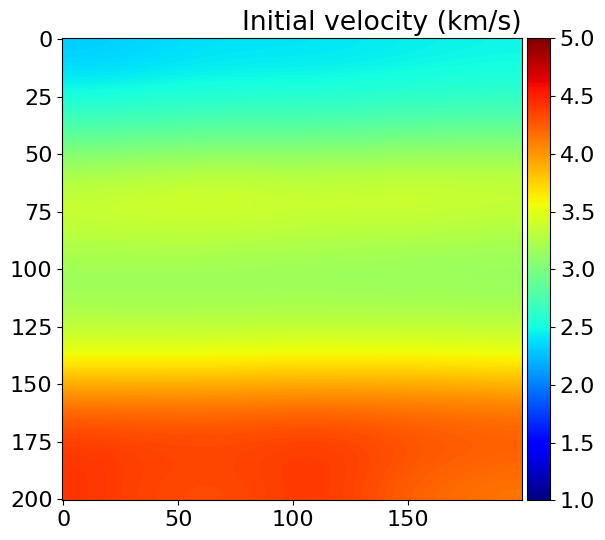

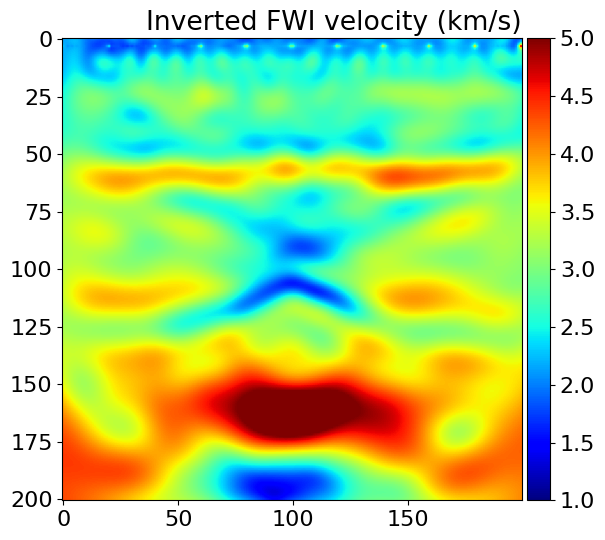

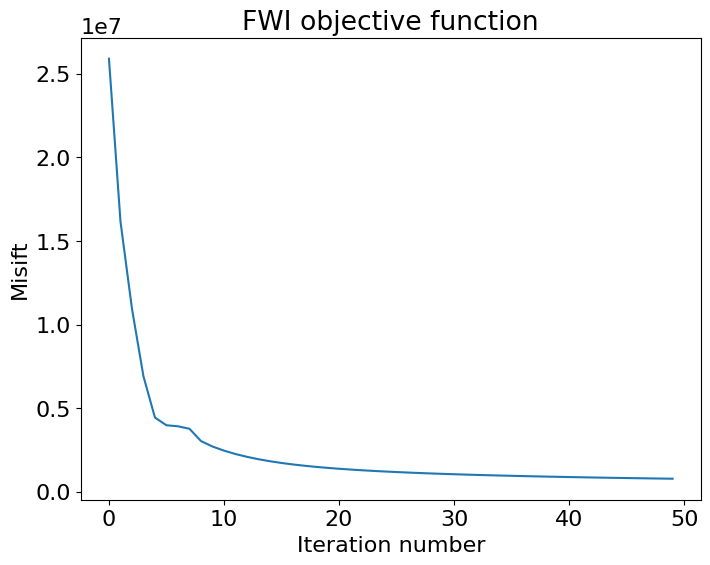

In [ ]:
nbl=30
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

From the Inverted FWI celocity image, it can be seen that the velocity model shows different underground velocity layers, and the velocity distribution shows a certain structure. However, in regions of higher or lower velocities, the image appears blurred, possibly due to numerical dispersion caused by the use of lower order discretization methods, which affects accurate simulation of the wave field.

From the FWI objective function image, as the number of iterations increases, the model fitting error gradually decreases, especially in the first 10 iterations. In subsequent iterations, the error decreases and levels off, indicating that the model may have approached the optimal solution or reached a local minimum.

__Analysis__
1. Ambiguous regions that may appear in velocity models are often related to numerical dispersion, especially in regions of high velocity gradients, which may indicate that the spatial discretization order is insufficient to accurately model the wavefield.
2. The effect in the boundary region in the image is less clear, which may be due to the absorbing boundary layer (nbl) being set not wide enough, or due to the lower order spatial discretization being insufficient to handle boundary reflections.
3. The setting of space_order=2 may limit the model resolution, especially in areas with complex geological structures.
4. Increase space_order to improve model accuracy and reduce numerical dispersion, however, this will increase the computational cost.

Then we increase the space_order to 4:

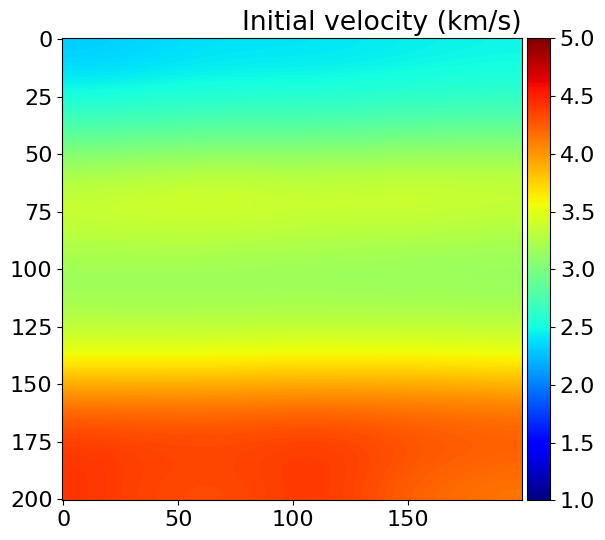

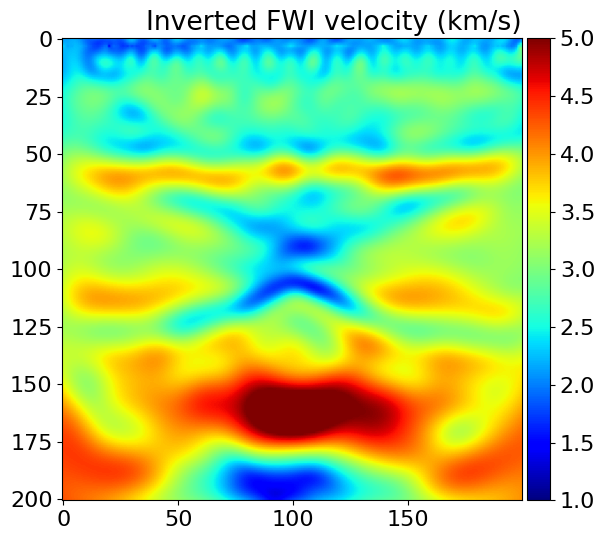

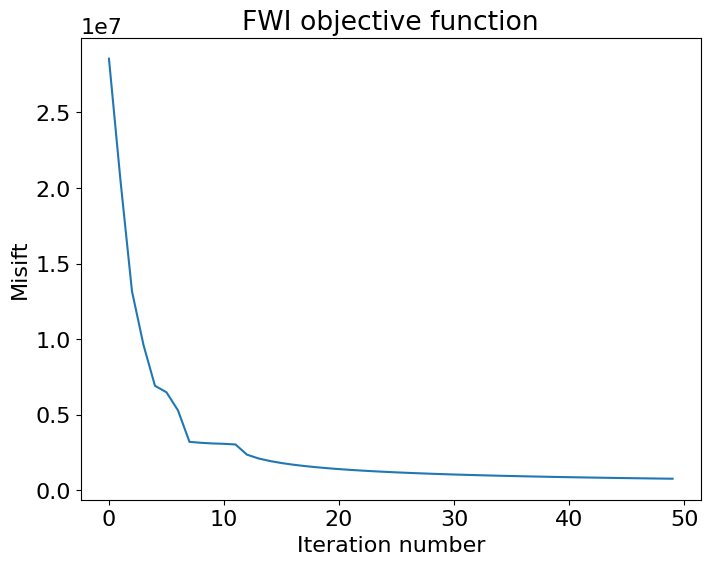

In [28]:
nbl=30
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=4)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

From the Inverted FWI celocity image, compared with the previous results with space_order=2, the velocity model obtained using a higher discretization order appears to have higher resolution, and the layers and interfaces of the underground structure are clearer. This shows that increasing the spatial discretization order can indeed improve the detailed performance of the model.

From the FWI objective function image, as the number of iterations increases, the error decreases in a trend similar to the case of space_order=2, but the error decreases to a lower level, which may mean that the inversion results are more consistent with the observed data.

__Analysis__
1. Increasing space_order to 4 helps reduce numerical dispersion, which manifests itself in the model as a cleaner subsurface velocity distribution, especially in regions with large velocity gradients.
2. Although the image shows a clearer subsurface structure, there may still be some small artifacts at the very edge of the model caused by improperly set absorption boundary conditions.
3. Increasing space_order tends to increase computational cost because more points need to be calculated to achieve higher order accuracy. This manifests itself in better results in images, but also means more computing resources and time are required.
4. Higher spatial discretization orders can improve the results of FWI, especially when inverting high-frequency information. This allows the model to better represent actual geological structures.
5. Increase space_order to improve model accuracy and reduce numerical dispersion, however, this will also increase the computational cost.

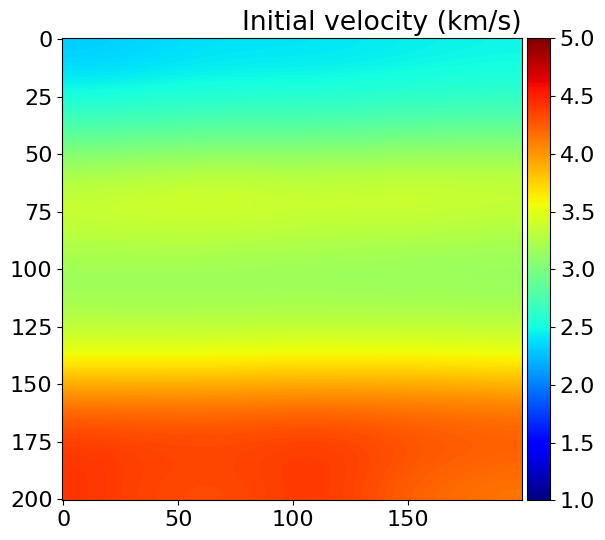

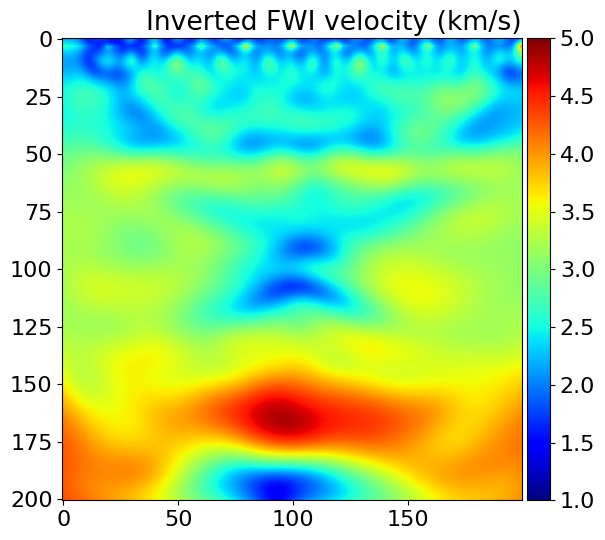

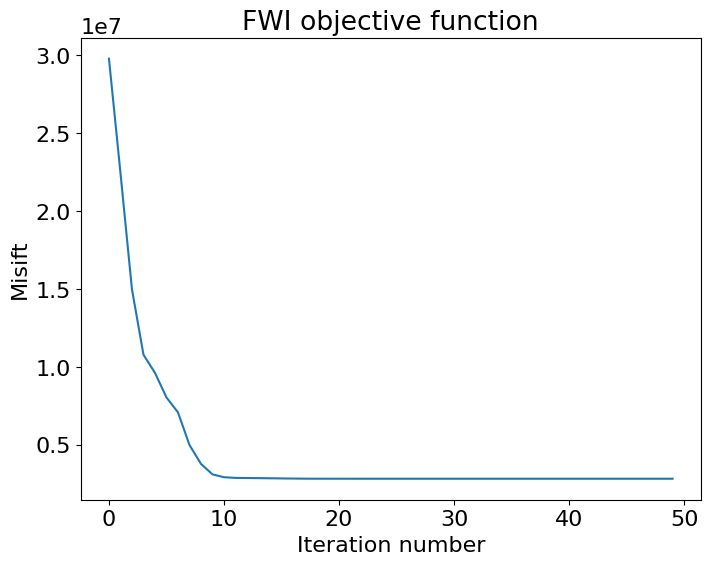

In [29]:
nbl=30
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=6, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=6)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

The Inverted FWI celocity figure shows a more refined velocity model compared to space_order=4. Subsurface structural features are clearer in the velocity model, especially in areas with higher velocities, and the resolution of detail is significantly improved. This shows that higher-order spatial discretization can capture more wavefield details, thereby improving the accuracy of the model.

From the FWI objective function image, the decreasing trend of the objective function is similar to the previous results of space_order=2 and space_order=4, with the error decreasing rapidly in the early stages of the iteration and then gradually leveling off. This shows that as the iteration proceeds, the fit between the model and the observed data gradually improves, but increasing the order of spatial discretization does not significantly affect the rate of error reduction.

__Analysis__
1. Increasing space_order to 6 may further reduce numerical dispersion, allowing the physics in the velocity model to be better restored, especially in regions with large wave speed variations.
2. The overall clarity and resolution of the images have been improved, which may allow for more accurate interpretation of geological features.
3. Although the images show better results, using higher order spatial discretization also implies a higher computational burden.
4. It is important to note that as the order of spatial discretization increases, the model may start to fit noise in the data, especially if the data quality is not high enough.
5. As keep increasing space_order would increase the computational cost, we finally set space_order to 6.

### Modification 4 - Changing the grid resolution

#### Discussion

As the line search algorithm has already been optimized in my previous part's work, I choose to do modification of the grid which would be much more complicated rather than simply change some number.

Changing the grid resolution affects the computational cost. The higher the resolution, the more computing resources are required and the longer the computing time. Therefore, we set the other parameters to the simplest ones, nbl=10, space_order=2



__Reasons for increasing the number of grid points__


Improve spatial resolution: Increasing the number of grid points reduces the size of the grid cells, thereby improving the spatial resolution of the model. This allows for more accurate capture of subtle changes in the subsurface medium, such as small-scale geological structures or velocity changes.

Reduce numerical dispersion: In numerical simulations, larger grid cells will lead to numerical dispersion of the waveform, that is, the change of wave speed with frequency, which does not exist in the actual physical world. Refinement of the mesh can reduce this numerical dispersion, making the wave propagation more consistent with physical reality.

Improve model accuracy: In FWI, we usually want the inversion results to be as close as possible to the velocity distribution of the real underground medium. By increasing the grid resolution, more data can be used in the inversion process and therefore a more accurate velocity model is possible.


__Impact on final imaging results__

Clearer underground structure: High-resolution grids can more clearly reveal the layers and details of underground structures, making imaging results more reliable and realistic.

Better geological interpretation: Finer grid resolution provides more detail, helping geologists more accurately interpret and analyze underground structures.

Increased computational cost: Increasing the grid resolution significantly increases the computational effort because more data points need to be processed with each iteration. This means that more powerful computing resources are required, and longer computing times are required.

I want to be able to reduce the spacing of the grid from 10m to 5m, but can't do it directly. Because there is not enough data in the original data v_sm to support this new resolution. The new grid has more points, and the original data is smaller in size and cannot be applied directly to the new grid. I use interpolation to fit the data to the new grid size. Because through interpolation, we can estimate the velocity values between the original sampling points, thus maintaining the continuity and smoothness of the data throughout the model. At the same time, interpolation can help us use existing data to infer the velocity value of unsampled locations as accurately as possible, thereby improving the overall accuracy of the model.

I use cubic spline interpolation for interpolation as it gives smooth and accurate results in most cases. Cubic spline interpolation is a technique used mathematically for function approximation to produce smooth curves and is suitable for interpolation of continuous data.



#### Practical Analysis

The first model with three figures is the model with the original grid resolution. And the second one is the model reducing the spacing of the grid from 10m to 5m.

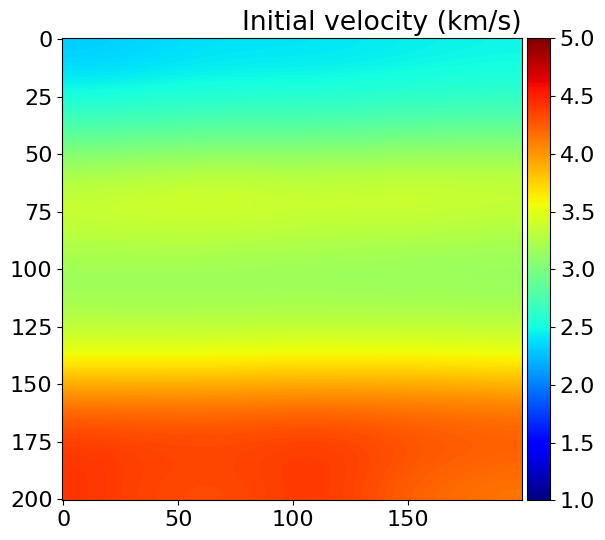

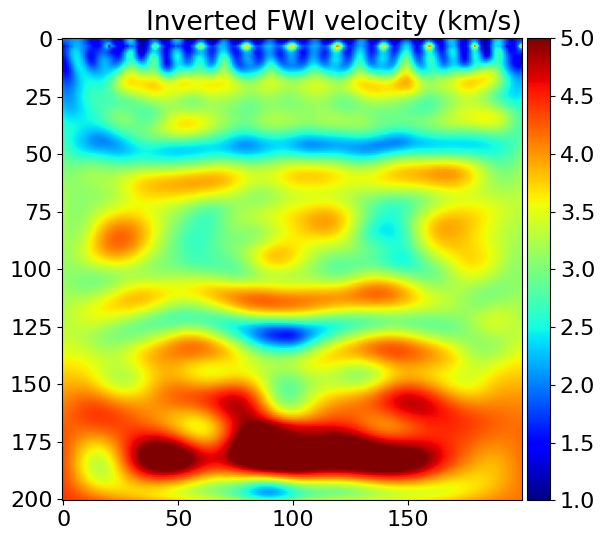

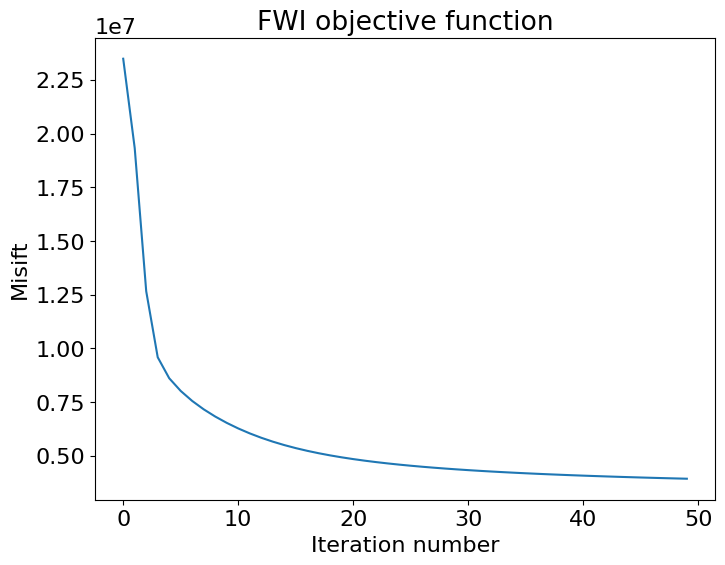

In [ ]:
model_modification(fwi_iterations=50)

In [ ]:
from scipy.ndimage import zoom

nbl=10
fwi_iterations=50
spacing = (5., 5.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

original_shape = v_sm.shape
new_shape = (original_shape[0]*2 - 1, original_shape[1]*2 - 1)

scale_factor = (new_shape[0] / original_shape[0], new_shape[1] / original_shape[1])
v_sm = zoom(v_sm, scale_factor, order=3)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_line_search(model0, optimize_fwi_gradient, direction, alpha=alpha)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

The result for the cell above is the following image, I clear the result by mistake and it would take long time to run this cell. Luckily, I have saved the result!
<img src="./grid.png">

__Analysis of the original model (first three graphs)__

FWI velocity model after inversion: The velocity model reveals the preliminary characteristics of the underground structure, but the stratigraphic interface and velocity changes are not very clear. This may be due to the lower spatial resolution resulting in limited detail capture capabilities.

FWI objective function: The objective function decreases with the number of iterations, showing that the model improves in fitting the data. The downward trend of the residuals is more obvious in the early iterations and gradually levels off as the number of iterations increases.

__Analysis of the results after increasing the resolution (second three graphs)__

FWI velocity model after inversion: After doubling the grid resolution, the velocity model shows a clearer subsurface velocity structure. The stratigraphic interface is more clearly identifiable, and the levels of velocity changes are more obvious, indicating that increasing the resolution enhances the analytical ability of the model.

FWI objective function: The absolute value of the objective function tends to stabilize after an initial decline. Although the absolute value of the residual becomes larger after adding grid points, this does not mean that the inversion results become worse, but because the increase in the number of grid points leads to an increase in the total data residual. Therefore, normalized residuals are required for valid comparisons.

To fairly compare the two models, we should consider the average residual for each data point, rather than the total residual. The average residual can be calculated by dividing the total residual by the number of data points. After the grid is reduced, we can conclude that the second image has four times the data volume of the first image. Therefore, the residual of the second image can be divided by 4 and compared with the residual of the first model.

__Conclusion:__

Resolution improvement: Increasing the mesh resolution can significantly improve the details of the model, resulting in a more refined subsurface velocity structure.

Residual comparison: When comparing the residuals of models with different resolutions, normalized residual values should be used so that the quality of the inversion results can be correctly evaluated.

Inversion quality: Although the absolute value of the residuals increases, if the normalized residuals decrease, or are at least of the same magnitude, this usually indicates better inversion results with increased resolution. This is exactly what happened to us.

Computing resources: Increasing the number of grid points increases the demand for computing resources. Therefore, in practical applications, we must find a balance between improving resolution and computing resources. When I was running a high-resolution model on my Mac, I was constantly reminded that the content was insufficient and the computer was very hot and laggy.

### EXTRA modification(this is the fifth, and I just want to try to simply implement this) - using `scipy.optimize.minimize` as the method of computing alpha

In [40]:
from scipy.optimize import minimize

def objective_function_for_alpha(alpha, model, direction, objective_function):
    alpha = alpha.item()
    saved_vp = Function(name="vp_old", grid=model0.grid,space_order=2)
    saved_vp.data[:] = model.vp.data.copy()

    update_with_box(model.vp, alpha, direction)
    
    new_obj, _ = objective_function(model.vp, flag=False)
    
    update_eq = Eq(model.vp, Max(Min(saved_vp, 5.0), 1.0))
    Operator(update_eq)()
    
    return new_obj

def optimize_alpha_with_scipy(model, direction, objective_function, alpha=1e-5):
    bounds = [(0, None)]

    x0 = [alpha]

    def objective_wrapper(alpha, model, direction, objective_function):
        return objective_function_for_alpha(alpha, model, direction, objective_function)

    res = minimize(fun=objective_wrapper, x0=x0, args=(model, direction, objective_function), bounds=bounds, method='L-BFGS-B')

    optimal_alpha = res.x.item()
    
    return optimal_alpha

# ...


In [ ]:
nbl=30
fwi_iterations=50
spacing = (10., 10.) # Values in meters
origin = (0., 0.)
v_sm = np.load('data/initial_model.npy', allow_pickle=True)

# Create a Devito model
model0 = Model(vp=v_sm, space_order=6, dtype=np.float32, nbl=nbl, grid=None,
            shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")


nsrc=11; nrcv=101;
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.
tn = 2000.
f0 = 0.005

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model0, geometry, space_order=6)

# Run FWI with gradient descent
alpha = 1e-5
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = optimize_fwi_gradient(model0.vp)
    
    alpha = optimize_alpha_with_scipy(model0, direction, optimize_fwi_gradient, alpha=alpha)
    update_with_box(model0.vp, alpha, direction)
    print('Iteration:', i, 'Objective:', objective[i], 'Alpha:', alpha)


plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()